# Mini Project 4 - Clustering

### Instructions on How to Run

1. **Open** the Jupyter Notebook for the Clustering project.
2. **Ensure** you have the following libraries installed:
   - **NumPy**
   - **Pandas**
   - **Matplotlib**
   - **scikit-learn**
   - **mpl_toolkits**
   - **SciPy** (for hierarchical clustering)
   - **OpenCV** (for image processing)
3. **Run** each cell in order from top to bottom.
4. The project uses two datasets:
   - **Synthetic Data:** Generated using scikit-learn’s `make_blobs` function with 300 instances, 4 centers, and a standard deviation of 0.6.
   - **RGB Image:** An image is loaded and its pixels (R, G, B values) are clustered to demonstrate image compression.
5. Each **section** prints outputs or plots that illustrate the clustering results and comparisons (e.g., different seeds for K-means, differences between K-means and K-means++ results, and the dendrogram for hierarchical clustering).


# Introduction

In this project we explore two unsupervised learning approaches for clustering:
1. **K-Means Clustering** – including both the standard algorithm and the improved K-Means++ initialization.
2. **Hierarchical Clustering** – using Ward’s method to determine the merging cost, with the final output visualized as a dendrogram.

The project is divided into two parts:
- **Part I:** Clustering on two datasets:
  - A synthetic dataset generated using `make_blobs`.
  - An RGB image used for image compression by clustering its R, G, and B values.
- **Part II:** Hierarchical clustering on the Mall Customers dataset.

# Importing the Necessary Libraries

In [1]:
import sklearn 
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from mpl_toolkits import mplot3d
from sklearn.metrics import pairwise_distances_argmin
#you can use Python’s imaging library (PIL)
from PIL import Image
from IPython.display import display
# or you can use opencv ## conda install anaconda::opencv
import cv2 #if you use cv2 remember to covert from BGR to RGB
import scipy.cluster.hierarchy as sch #you only for sch.dendrogram


In [2]:
X, y = make_blobs(n_samples = 300, centers = 4, cluster_std = 0.6, random_state=42)

In [3]:
X.shape

(300, 2)

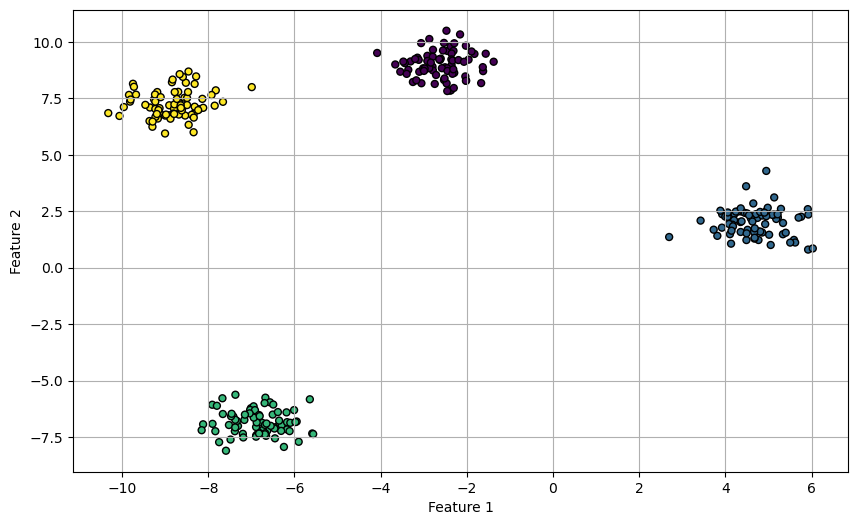

In [4]:
plt.figure(figsize = (10,6))
plt.scatter(X[:, 0], X[: , 1], c = y, edgecolor = 'k', s = 25)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

# Standard K-Means Clustering

We implement K-Means as follows:

1. **Initialization**:
   - Randomly select `k` centers using a helper function (e.g. using `np.random.choice`).

2. **Assignment**:
   - For every point, compute its Euclidean distance to each centroid using `sklearn.metrics.pairwise_distances_argmin`.
   - Assign the point to the nearest centroid.

3. **Update**:
   - Compute new centroids as the mean of all points assigned to each cluster.

4. **Convergence**:
   - Iterate until the maximum change in centroids is less than a small value (`epsilon`) or until reaching the maximum number of iterations.


In [5]:
def initializeRandomCenters(X, k):
    n = len(X)
    indices = np.random.choice(n, k, replace=False)        
    return X[indices]
    

In [6]:
def KMeans(X, k, max_iterations=1000, epsilon=1e-4, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
        
    # Initialize k random centroids from the data.
    centroids = initializeRandomCenters(X, k)
    
    for i in range(max_iterations):
        # Assign each data point to the nearest centroid using pairwise distances.
        labels = pairwise_distances_argmin(X, centroids)
        
        # For each cluster, compute the new centroid as the mean of all points assigned to that cluster.
        new_centroids = np.array([
         X[labels == j].mean(axis=0) if np.any(labels == j) else centroids[j]
            for j in range(k)])
        
        # Compute the shifts of the centroids.
        centroid_shifts = np.linalg.norm(new_centroids - centroids, axis=1)
        
        if np.max(centroid_shifts) < epsilon:
            centroids = new_centroids
            print(f"Converged at iteration {i+1}")
            break
        
        centroids = new_centroids

    return labels, centroids

Converged at iteration 4


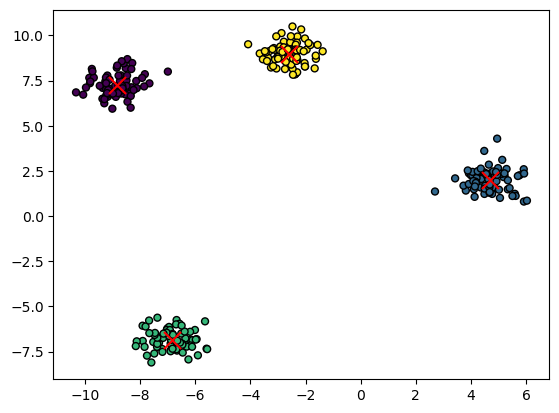

In [7]:
labels, centroids = KMeans(X, k = 4)

plt.scatter(X[:, 0], X[:, 1], c = labels, edgecolor = 'k', s = 25)
plt.scatter(centroids[:, 0], centroids[:, 1], c = 'red', marker = 'x', s = 150)
plt.show()

Converged at iteration 12


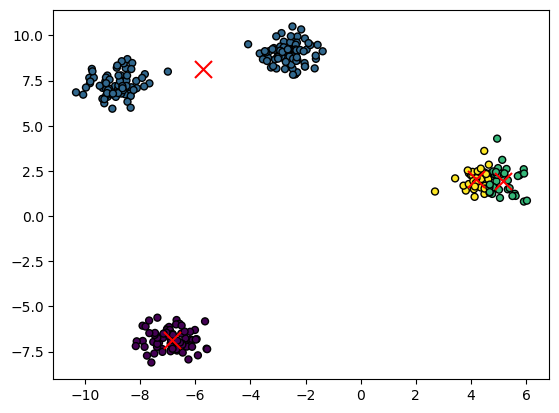

In [8]:
labels, centroids = KMeans(X, k = 4, random_state = 2)

plt.scatter(X[:, 0], X[:, 1], c = labels, edgecolor = 'k', s = 25)
plt.scatter(centroids[:, 0], centroids[:, 1], c = 'red', marker = 'x', s = 150)
plt.show()

### Comparing Results from Different Seeds

- **Fixed Seed (here, seed = 2):**
  - With a fixed seed, the random initialization is reproducible. That is, every time you run the algorithm, the same initial centroids are selected. As a result, the centroids always converge to exactly the same positions and the algorithm terminates at the same iteration number.
  - However, when you visually inspect the plotted centroids (marked in this case as crosses), you may notice that they do not always appear exactly where you expect them to be. This is because the standard K‑Means algorithm is highly sensitive to its initialization. So, if the initial centroids are not well‐placed relative to the true cluster structure, even with a fixed seed the final centroids may not align perfectly with the intuitively “correct” centers.

- **Random Seed (No seed specified):**
  - When no seed is fixed (i.e., random initialization), each run of the algorithm produces a different set of initial centroids. Consequently, the algorithm can converge to different final centroids in different runs.
  - This means that if you keep re-running the code, you might sometimes see centroids that are perfectly aligned with the expected cluster centers, and at other times the algorithm might converge to a solution where, for example, distant clusters are mistakenly merged (reflected by centroids being misplaced or clusters being assigned incorrect colors).
    

Therefore, the variability with random seeding demonstrates the sensitivity of standard K‑Means to its initial conditions. Even though the underlying data structure remains the same, the final clustering outcome may vary from run to run.


# K-Means++

# K-Means++ Clustering

K-Means++ improves on standard K-Means by using a smarter initialization:

1. **Step 1: Random Initialization**
   - Randomly select the first centroid from the data points.

2. **Step 2: Distance Computation**
   - For each data point, compute its distance to the closest centroid that has already been chosen.

3. **Step 3: Select Next Centroid**
   - Choose the next centroid as the point that is furthest from the nearest centroid, or with a probability proportional to the squared distance.

4. **Repeat Initialization**
   - Continue Steps 2 and 3 until `k` centroids have been selected.

5. **Standard K-Means Update**
   - Run the standard K-Means update steps:
     - **Assignment**: Assign each data point to the nearest centroid.
     - **Update**: Compute new centroids as the mean of all points assigned to each cluster.


In [9]:
def initializeFirstCentroid(X):
    n = len(X)
    random_index = np.random.randint(0,n)   
    return X[random_index]
    

In [10]:
def KMeans_Plus_Plus(X, k, max_iterations=1000, epsilon=1e-4, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    # First we select one random centroid.
    centroids = [initializeFirstCentroid(X)]
    
    # Iteratively add new centroids until we have k.
    while len(centroids) < k:
        # For each data point, compute its distance from the nearest centroid.
        distances = np.array([
            min(np.linalg.norm(x - c) for c in centroids)
            for x in X])
        
        # Choose the next centroid as the point with the maximum distance.
        new_index = np.argmax(distances)
        centroids.append(X[new_index])
    
    centroids = np.array(centroids)

    
    for i in range(max_iterations):
        # Assign each point to its nearest centroid .
        labels = pairwise_distances_argmin(X, centroids)
        
        # Update each centroid as the mean of all points assigned to it.
        new_centroids = np.array([
            X[labels == j].mean(axis=0) if np.any(labels == j) else centroids[j]
            for j in range(k)])
        
        # Compute the shift for each centroid.
        centroid_shifts = np.linalg.norm(new_centroids - centroids, axis=1)
        
        if np.max(centroid_shifts) < epsilon:
            centroids = new_centroids
            print(f"Converged at iteration {i+1}")
            break
        
        centroids = new_centroids

    return labels, centroids

Converged at iteration 2


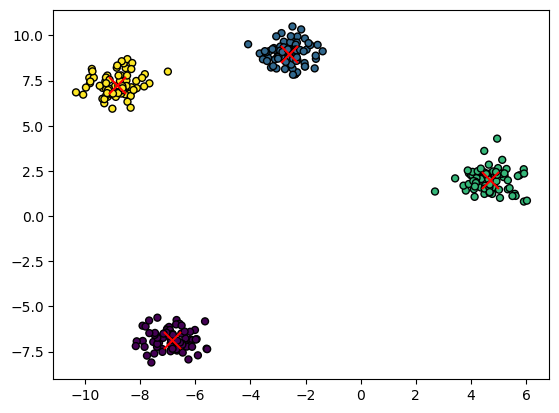

In [11]:
labels, centroids = KMeans_Plus_Plus(X, k = 4)

plt.scatter(X[:, 0], X[:, 1], c = labels, edgecolor = 'k', s = 25)
plt.scatter(centroids[:, 0], centroids[:, 1], c = 'red', marker = 'x', s = 150)
plt.show()

Converged at iteration 2


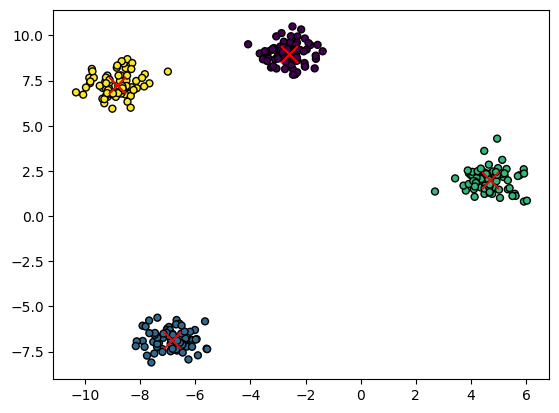

In [12]:
labels, centroids = KMeans_Plus_Plus(X, k = 4, random_state = 2)

plt.scatter(X[:, 0], X[:, 1], c = labels, edgecolor = 'k', s = 25)
plt.scatter(centroids[:, 0], centroids[:, 1], c = 'red', marker = 'x', s = 150)
plt.show()

### Comparing Results from Different Seeds

- **K-Means++ with Fixed Seed (here, seed = 2):**
  - With a fixed seed, the K-Means++ initialization is completely reproducible. Every time you run the algorithm with the same seed, it selects exactly the same initial centroid.
  - Consequently, the final cluster assignments, centroids’ positions, and the number of iterations required for convergence are identical across runs.
  - Visually, the plotted centroids (marked in this case with crosses) appear in the same, expected locations every time.

- **K-Means++ without a Fixed Seed (Random Initialization):**
  - Interestingly, even when no seed is provided (i.e., allowing for random initialization), K-Means++ consistently produces the same clustering outcome on a given dataset.
  - In other words, regardless of re-running the algorithm with or without setting a random seed, you observe the same cluster assignments, centroids’ locations, and convergence iteration count.
  - This consistency indicates that the smarter initialization scheme in K-Means++, which selects subsequent centroids based on the distances from the already chosen centroids, is robust enough to consistently identify the “best” starting points.
  - The centroids are positioned exactly where they should be relative to the data structure, and the algorithm converges reliably (and pretty fast too), unlike standard K-Means where the results can vary significantly between runs (in the case with random seeding).


Therefore, K-Means++ significantly improves upon standard K-Means by providing a deterministic and robust initialization. This results in consistent clustering results (with or without a fixed random seed), better alignment of centroids with the true data structure, and predictable convergence behavior.


# Clustering an RGB Image for Compression

For image compression we use K-Means & KMeans++ to quantize the colors in an image:

1. **Load the image**:
   - Use OpenCV to load the image and convert it from BGR to RGB.

2. **Reshape the image**:
   - Reshape the image into an `n×3` matrix, where each row represents a pixel’s RGB value.

3. **Run K-Means**:
   - Apply K-Means and K-Means++ on the pixel values to obtain cluster centers (colors).

4. **Recreate the image**:
   - Replace each pixel with its corresponding cluster's centroid color.

5. **Display the result**:
   - Display the original image and the quantized image side by side.


## RGB Using KMeans (Unseeded)

In [13]:
image = cv2.imread("cropped.jpg") 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pixels = image.reshape(-1, 3)  # Flatten the image into an n x 3 matrix

In [14]:
labels, centroids = KMeans(pixels, 8, max_iterations=1000, random_state=None)

Converged at iteration 81


In [15]:
k_means_pixels = centroids[labels]
k_means_image = k_means_pixels.reshape(image.shape).astype(np.uint8)

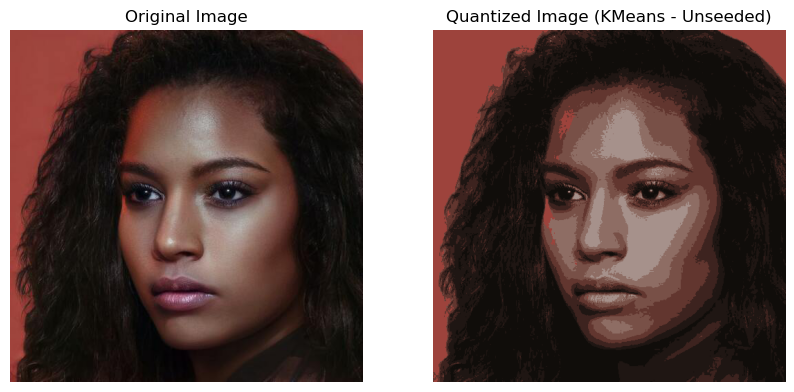

In [16]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(k_means_image)
plt.axis("off")
plt.title("Quantized Image (KMeans - Unseeded)")
plt.show()

## RGB Using KMeans (Seeded)

In [17]:
labels, centroids = KMeans(pixels, 8, max_iterations=1000, random_state=2)

Converged at iteration 77


In [18]:
k_means_pixels = centroids[labels]
k_means_image = k_means_pixels.reshape(image.shape).astype(np.uint8)


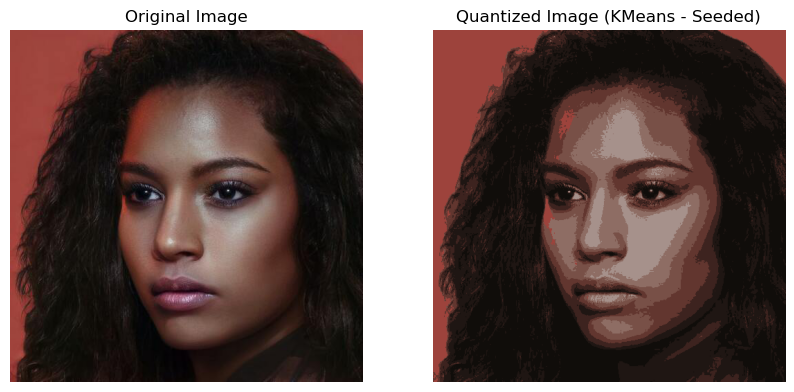

In [19]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(k_means_image)
plt.axis("off")
plt.title("Quantized Image (KMeans - Seeded)")
plt.show()

## RGB Using KMeans++ (Unseeded)

In [20]:
labels, centroids = KMeans_Plus_Plus(pixels, 8, random_state=None)

Converged at iteration 64


In [21]:
k_means_plus_plus_pixels = centroids[labels]
k_means_plus_plus_image = k_means_plus_plus_pixels.reshape(image.shape).astype(np.uint8)

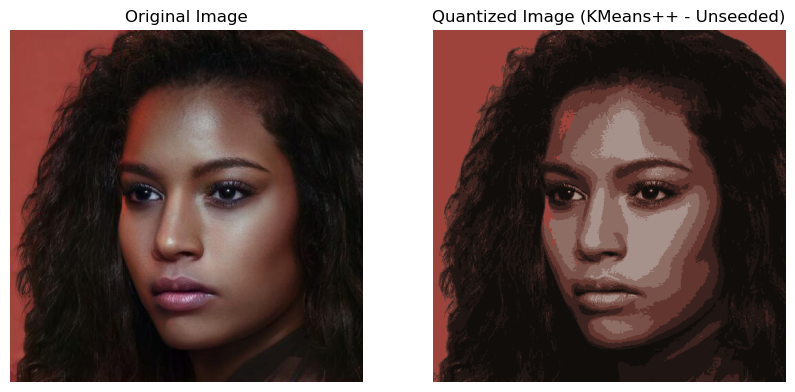

In [22]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(k_means_plus_plus_image)
plt.title("Quantized Image (KMeans++ - Unseeded)")
plt.axis("off")
plt.show()

## RGB Using KMeans++ (Seeded)

In [23]:
labels, centroids = KMeans_Plus_Plus(pixels, 8, random_state=2)

Converged at iteration 87


In [24]:
k_means_plus_plus_pixels = centroids[labels]
k_means_plus_plus_image = k_means_plus_plus_pixels.reshape(image.shape).astype(np.uint8)

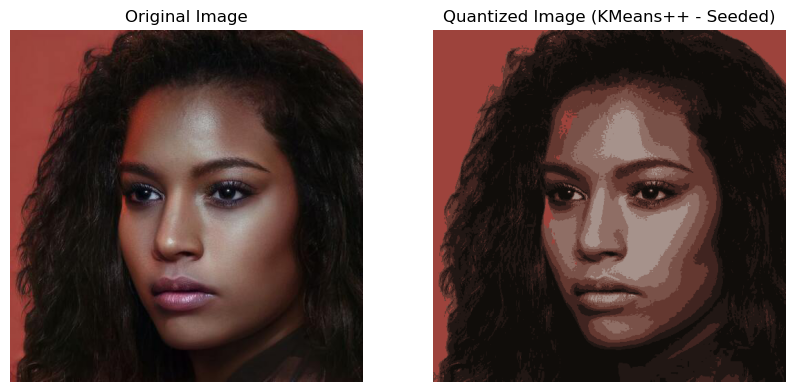

In [25]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(k_means_plus_plus_image)
plt.title("Quantized Image (KMeans++ - Seeded)")
plt.axis("off")
plt.show()

### Comparing all Results from Different Methods & Seeds

#### Standard K‑Means

- **Seeded (Fixed Seed):**
  - The algorithm converges in a certain number of iterations (e.g., 77 iterations in one run), as expected.
  
- **Unseeded (Random Initialization):**
  - Convergence happens in a different number of iterations (e.g., 81 iterations in one run), which shows the variability in convergence points when the algorithm is run multiple times on the same image (without seeding).
  

Despite the different convergence counts, the final images appear similar overall. While the quantized images look nearly identical to the naked eye, a closer look reveals that there are several subtle differences in color assignment due to centroid initialization.


#### K‑Means++ 

- **Seeded (Fixed Seed):**
  - Convergence occurs at a fixed iteration count (e.g., 87 iterations), yet the quantized image remains nearly identical in appearance.
  
- **Unseeded (Random Initialization):**
  - The algorithm converges at yet another different iteration count (e.g., 64 iterations), but the final output remains consistent.
 
For the case of KMeans++, visually, the differences in the seeded and unseeded versions are much lesser than it was with the standard KMeans algorithm, possibly because of the smarter initialization scheme in K-Means++. However, if you observe all four images, it is quite evident that all four images look reasonably similar. You would need to look really closely in order to notice the differences.  


#### Overall Comparison of K‑Means vs. K‑Means++ (Seeded and Unseeded)

- **Standard K‑Means:**
  - *Seeded:* Produces reproducible results with fixed initial centroids, yet convergence isn’t particularly fast and minor differences in cluster placements can be observed on close inspection (visible changes in centroid placements can be observed in the case of the cluster plots).
  - *Unseeded:* Varies in convergence iteration count due to random initialization. Int he case of the RGB image, final results are visually similar, though subtle centroid shifts may be noticeable. However, in the case of the cluster plots, the two plots were almost completely different.

- **K‑Means++:**
  - *Seeded:* Offers consistent and stable cluster assignments with a fixed seed, resulting in nearly identical quantized images and cluster plots.
  - *Unseeded:* Despite random initialization, the smarter initialization leads to almost identical outputs compared to the seeded version for the RGB image and exactly identical output in the case of the cluster plot.

**Summary:**  
Across both the synthetic blob clustering and RGB image quantization tasks, K‑Means++ generally provides more robust and consistent results regardless of seeding. Standard K‑Means is more sensitive to its initialization, leading to variability in convergence behavior and subtle differences in cluster centroids when not seeded.


# Hierarchical Clustering – Ward’s Method

Hierarchical clustering builds a tree (dendrogram) of clusters by progressively merging (or splitting) clusters based on a chosen distance metric. In **Ward's method**, the distance between two clusters is defined as the increase in the total within‐cluster sum of squares (SSE) when they are merged.

Mathematically, for two clusters \(A\) and \(B\) with centroids \(m_A\) and \(m_B\), the Ward distance Delta is given by:

$$
\Delta = \sqrt{2\,(SSE_{A \cup B} - SSE_A - SSE_B)}
$$

Where:
- **\(SSE_A\)** is the sum of squared distances between the points in cluster \(A\) and its centroid \(m_A\).
- **\(SSE_B\)** is the sum of squared distances between the points in cluster \(B\) and its centroid \(m_B\).
- **\(SSE_{A U B}\)** is the sum of squared distances for the merged cluster \(A U B\).

The goal of Ward's method is to merge the pair of clusters that minimizes Delta, thereby keeping the increase in within-cluster variance as low as possible. This approach tends to produce clusters of relatively similar size and minimizes the total variance within each cluster.


## Loading the Dataset & Data Pre-Processing

For this part we use the Mall Customers dataset. The steps are:
1. Load the CSV file (`Mall_Customers.csv`).
2. Convert categorical columns "Geneder" into numerical values using one-hot encoding (For example, map Male to 1 and Female to 0.)
3. Remove unnecessary columns (like CustomerID) and select only numeric features.

In [26]:
mall_df = pd.read_csv("Mall_Customers.csv")
mall_df['male'] = (mall_df['Gender'] == 'Male').astype(int)
mall_df['female'] = (mall_df['Gender'] == 'Female').astype(int)
X = mall_df.values


In [27]:
# Using one-hot encoding to create individual gender columns
X = mall_df.select_dtypes(include=[np.number]).iloc[:, 1:].values 

In [28]:
X

array([[ 19,  15,  39,   1,   0],
       [ 21,  15,  81,   1,   0],
       [ 20,  16,   6,   0,   1],
       [ 23,  16,  77,   0,   1],
       [ 31,  17,  40,   0,   1],
       [ 22,  17,  76,   0,   1],
       [ 35,  18,   6,   0,   1],
       [ 23,  18,  94,   0,   1],
       [ 64,  19,   3,   1,   0],
       [ 30,  19,  72,   0,   1],
       [ 67,  19,  14,   1,   0],
       [ 35,  19,  99,   0,   1],
       [ 58,  20,  15,   0,   1],
       [ 24,  20,  77,   0,   1],
       [ 37,  20,  13,   1,   0],
       [ 22,  20,  79,   1,   0],
       [ 35,  21,  35,   0,   1],
       [ 20,  21,  66,   1,   0],
       [ 52,  23,  29,   1,   0],
       [ 35,  23,  98,   0,   1],
       [ 35,  24,  35,   1,   0],
       [ 25,  24,  73,   1,   0],
       [ 46,  25,   5,   0,   1],
       [ 31,  25,  73,   1,   0],
       [ 54,  28,  14,   0,   1],
       [ 29,  28,  82,   1,   0],
       [ 45,  28,  32,   0,   1],
       [ 35,  28,  61,   1,   0],
       [ 40,  29,  31,   0,   1],
       [ 23,  

In [29]:
def computeSumofSquaredEuclidean(points, centroid):
    total = 0
    
    for k in points:
        total += np.sum((X[k] - centroid) ** 2)
        
    return total

In [30]:
n_shape = X.shape[0]
next_cluster_id = n_shape
merge_history = [] # Stores merge details for hierarchical clustering


# Initialize clusters where each data point starts as its own cluster
clusters = {}
for i in range(n_shape):
    clusters[i] = [i]


# Initialize centroids where each data point is its own centroid
centroids = {}
for i in range(n_shape):
    centroids[i] = X[i]

while len(clusters) > 1:
    best_pair = None
    best_ward_distance = float('inf')
    cluster_ids = list(clusters.keys())
    cluster_size = len(cluster_ids)

    # Iterate over all pairs of clusters to find the best pair to merge
    for i in range(cluster_size):
        for j in range(i + 1, cluster_size):
            a = cluster_ids[i]
            b = cluster_ids[j]

            # Retrieve the data points belonging to each cluster
            points_a = clusters[a]
            points_b = clusters[b]

            # Compute the sum of squared Euclidean distances for each cluster
            sqd_euclidean_a = computeSumofSquaredEuclidean(points_a, centroids[a])
            sqd_euclidean_b = computeSumofSquaredEuclidean(points_b, centroids[b])

            # Combine both clusters' points
            combined_points = points_a + points_b

            # Extract the values of the combined points from X
            points_values = []
            for m in combined_points:
                points_values.append(X[m])

            # Compute the centroid of the merged cluster
            combined_centroid = np.mean(points_values, axis=0)
            sqd_euclidean_combined = computeSumofSquaredEuclidean(combined_points, combined_centroid)            

            # Compute the Ward's linkage distance
            ward_temp = 2*(sqd_euclidean_combined - sqd_euclidean_a - sqd_euclidean_b)
            ward_temp = max(0, ward_temp) # In order to avoid errors due to square root of a negative number
            ward_distance = np.sqrt(ward_temp)

            if ward_distance < best_ward_distance:
                best_ward_distance = ward_distance
                best_pair = (a, b)

    # Merge the best pair of clusters
    a, b = best_pair
    new_cluster_id = next_cluster_id
    next_cluster_id += 1

    combined_points = clusters[a] + clusters[b]
    
    points_data = []
    for i in combined_points:
        points_data.append(X[i])
        
    combined_centroid = np.mean(points_data, axis=0)

    # Store merge details
    merge_detail = [a, b, best_ward_distance, 0]
    merge_history.append(merge_detail)

    # Update clusters with the new merged cluster
    clusters[new_cluster_id] = combined_points
    centroids[new_cluster_id] = combined_centroid

    # Remove the old clusters from the dictionary
    del clusters[a]
    del clusters[b]
    del centroids[a]
    del centroids[b]

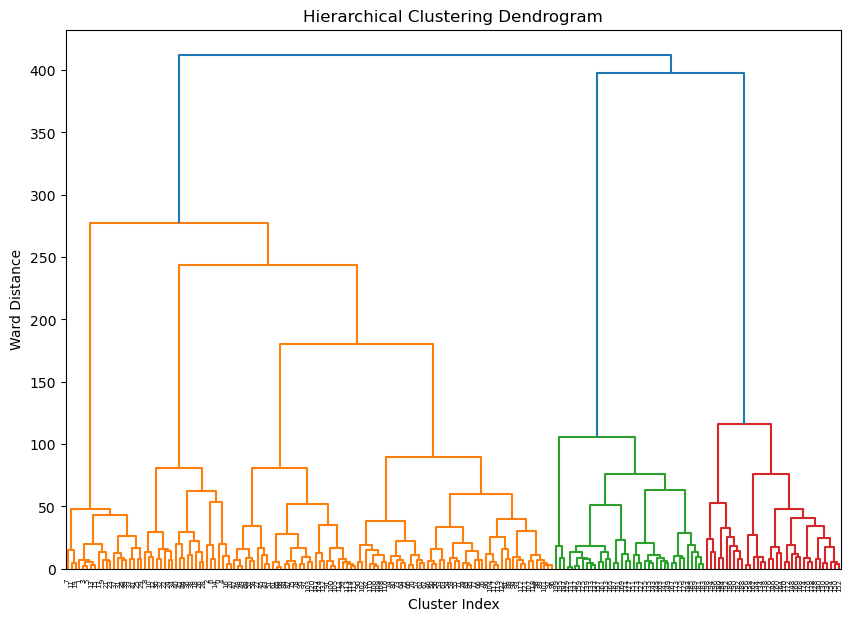

In [31]:
linkage_matrix = np.array(merge_history)

# Plot the dendrogram
plt.figure(figsize=(10, 7))
sch.dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Index')
plt.ylabel('Ward Distance')
plt.show()